# Manual Train CCtRNN Model on Single XOR Task 


## Imports 


In [1]:
# === SYSTEM PATH SETUP ===
import sys
from pathlib import Path
import copy

# Set the project root (the directory containing 'src/')
project_root = Path("/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus")
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# === STANDARD SCIENTIFIC LIBRARIES ===
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# === CUSTOM LIBRARIES ===
from src.utils.config_handling import create_experiment_config
from src.data.data_generation import DataGenerator
from src.models.experiment_network import ExperimentNetwork
from src.training.trainers.StandardTrainer import StandardTrainer
from src.analysis.visualisation import plot_training_analysis, plot_trial_type_comparison, plot_decoding_time, plot_decoding_learning
from src.models.model_factory import load_checkpoint_models
from src.analysis.utils import get_models_activations, identify_trial_types, get_percentile_indices, combine_phase_results
from src.analysis.representations import decode_across_epochs_and_time
from src.experimenting.experiment_running import Experiment, ExperimentRunner

# === PLOTTING SETUP ===
sns.set_theme(context='notebook')
%config InlineBackend.figure_format = 'retina'  # 'svg' also works

## Step 1: Create Experiment Configuration

In [ ]:
# -------------------------------------------------------------------------
# Step 1: Define and save the experiment configuration dictionary
# -------------------------------------------------------------------------
# We use the `create_experiment_config` utility to generate a hierarchical
# config object that specifies all key parameters for:
# - the temporal structure of each trial,
# - the dataset/task setup,
# - the model architecture (including controller),
# - training hyperparameters,
# - and hardware + reproducibility options.
#
# This config is automatically saved to disk as a YAML file, and can be 
# loaded later to reproduce the same experiment.

# Path to save the generated config file
save_path = Path("/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/configs")
config_fname = 'demo_singletask.yml'
config_path = save_path / config_fname

# Create the config dictionary and save it to disk
config = create_experiment_config(
    experiment_name="demo_singletask",  # Used to tag results and logs
    save_path=save_path,
    config_fname=config_fname,
    overwrite=True,  # Overwrite any existing config with same name

    # ---- Temporal structure of trials (ms) ----
    temporal={
        't_min': -500,            # Start time of trial
        't_max': 1500,            # End time of trial
        'dt': 20,                 # Time resolution (ms per step)
        'colour_onset': 0.0,      # When color cue starts
        'colour_offset': 1000.0,  # When color cue ends
        'shape_onset': 500.0,     # When shape cue starts
        'shape_offset': 1000.0,   # When shape cue ends
        'reward_onset': 1000.0,   # Reward cue starts
        'reward_offset': 1200.0   # Reward cue ends
    },

    # ---- Task and dataset configuration ----
    data={
        'n_trials': 512,               # Total number of trials
        'input_noise_std': 0.0,        # Gaussian noise added to inputs
        'batch_size': 32,               # Training batch size
        'num_workers': 0,               # DataLoader worker threads
        'encoding_mode': 'orthogonal',  # How task features are encoded
        'experiment_type': 'abstract_binary',  # Task family (e.g. XOR, AND)
        'task_indices': [14]            # Which abstract task(s) to use
    },

    # ---- Hardware / precision / reproducibility ----
    hardware={
        'device': 'cpu',           # Options: 'cpu', 'cuda', 'mps'
        'precision': 'float32',    # Tensor precision
        'deterministic': True      # Force deterministic ops for reproducibility
    },

    # ---- Model architecture and controller settings ----
    model={
        'type': 'ExperimentNetwork',     # Dispatches to CCtRNN + controller

        # Learning rule configuration
        # Learning rule configuration
        'learning_rule': 'lora',  # Can be 'standard_bp' 'lora'.
        'learning_rule_params': {'output_layer': False,
                                 'lambda_orth': 100.0, #
                                 'lora_strength': 1.0, # Scaling for LoRA weights contribution to controller outut
                                 'lora_rank': 1, 
                                 'lora_init_g': 0.1,
                                 'penalty_types': {'basis_overlap': True,
                                                   'weight_overlap': False,
                                                   'signal_overlap': False, 
                                                   'intra_basis_overlap': False,}, 
                                 'concat_past_bases': False ,  # If True, concatenate past LoRA bases instead of adding
                                },    

        # Core RNN parameters (cortical dynamics)
        'network': {
            'input_size': 3,             # 3 input channels (task + features)
            'hidden_size': 150,           # Size of cortical recurrent population
            'output_size': 2,            # Binary output (reward / no reward)
            'tau': 50.0,                 # Membrane time constant (ms)
            'dt': 20.0,                  # Integration step (ms)
            'noise_std': 0.0,           # RNN Gaussian noise
            'nonlinearity': 'relu',      # Activation function
            'init_method': 'normal',     # Weight init scheme
            'init_g': 1.2               # Scaling of initial weights
        },

        # Optional random input layer
        'random_input': {
            'enabled': False,  # Whether to use random input expansion layer module
            'size': 30         # Size of random input layer
        },

        # Cerebellar controller configuration
        'controller': {
            'enabled': True,               # Whether to use controller module
            'type': 'simple',              # Controller class (e.g. simple, bioplausible - in future)
            'controller_hidden_size': 50,  # Hidden layer width (these args assume simple FF controller for now)
            'controller_hidden_n': 0,      # Number of controller hidden layers
            'controller_init_method': 'normal',
            'controller_init_g': 0.1,
            'nonlinearity': 'relu',
            'output_activation': 'relu',   # Output activation (post controller)
            'output_size': 5               # Size of controller input to RNN hidden layer
        },
    },

    # ---- Plasticity / trainable pathways ----
    plasticity={
        'input_plastic': False,             # Train input → hidden?
        'hidden_plastic': False,            # Train recurrent weights?
        'output_plastic': False,             # Train hidden → output?
        'h2controller_plastic': True,       # Train hidden → controller?
        'controller2h_plastic': False,       # Train controller → hidden?
        'controller_hidden_plastic': False   # Train controller internal weights?
    },

    # ---- Training hyperparameters ----
    training={
        'optimizer': 'Adam',
        'n_epochs': 50,
        'lr_rnn': 0.001,                    # Learning rate for RNN weights
        'lr_controller': 0.0015,             # Learning rate for controller weights
        'loss_type': 'crossentropy',
        'activations_l2': 0.0,              # L2 penalty on hidden activations
        'weight_decay': 0.002,                # L2 penalty on weights
        'checkpoint_overwrite': True,       # Overwrite previous model?
        'checkpoint_path': "/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/results/singletask_training/model_callbacks/testmodel1.pt",
        'checkpoint_frequency': 1           # Save every N epochs
    },

    # ---- Reproducibility ----
    reproducibility={
        'run_multiple': True,  # Disable multiple seed runs for now
        'seed': 100,             # Base random seed
        'n_seeds': 3,           # Number of distinct seeds (if run_multiple)
        'seed_increment': 77    # Increment between seeds
    }
)

Overwriting configuration file at /Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/configs/demo_singletask.yml


## Step 2: Initialise the Data Generator

In [ ]:
# -------------------------------------------------------------------------
# Step 2: Initialise the Data Generator
# -------------------------------------------------------------------------
# This component produces structured input-output pairs for training.
# It uses the config to determine:
# - the timing of stimulus cues (color, shape, reward windows)
# - how inputs are encoded (e.g., orthogonal, one-hot)
# - which abstract task(s) to generate
# - number of trials and batch size

# Provide only the config path — everything else is parsed automatically
data_generator = DataGenerator(config_path=config_path)

# Plot to verify setup
data_generator.plot_experiment_summary()

## Step 3: Create the Model




In [ ]:
# -------------------------------------------------------------------------
# Step 3: Initialize the Model
# -------------------------------------------------------------------------
# This constructs the full ExperimentNetwork using the CCtRNN and controller.
# It uses config['model'] for architecture and plasticity settings.


# Set seed for reproducibility
ExperimentNetwork.set_seed(config['reproducibility']['seed'])

# Create model instance using unpacked config
model = ExperimentNetwork(
    plasticity_params=config['plasticity'],
    controller_params=config['model']['controller'],
    rnd_input_params=config['model']['random_input'],
    learning_rule=config['model']['learning_rule'],
    learning_rule_params=config['model']['learning_rule_params'],
    **config['model']['network']
)

# Move model to the correct device
device = config['hardware']['device']
model.to(device=device)

## Step 4: Train the Model

In [ ]:
trainer = StandardTrainer(model, config, data_generator)
results = trainer.train()
plot_training_analysis([results])
plot_trial_type_comparison(data_generator, model, config['hardware']['device'])

## Step 5: Representational Analyses



In this section, we evaluate the trained model's performance beyond loss.

We analyze internal representations using decoding, cross-generalization, firing rates, and trial-type specific behavior.

In [ ]:
# -------------------------------------------------------------------------
# Step 5: Representation Analysis – Extract Activations
# -------------------------------------------------------------------------
# This cell loads the trained model from checkpoint and generates fresh
# validation data to evaluate the internal activations across trials.
# These activations are used for representational decoding analyses.

# Load trained model from checkpoint
models = load_checkpoint_models(Path(config['training']['checkpoint_path']))
model = models[0]  # Extract single model from list

# Generate fresh validation data
val_data_generator = DataGenerator(config=config)
val_data_generator.set_seed(31)  # For reproducibility
X, y, trial_types = val_data_generator.generate_data(
    input_noise_std=config['data']['input_noise_std'],
    n_trials=512,
    return_trial_types=True
)
mask = val_data_generator.generate_mask(mask_format='bool')

# Extract hidden activations from model
activations, acc = get_models_activations(models, X, y, mask)

In [ ]:
# Run decoding analysis
activations_time_averaged = np.mean(activations[:,:,49:74,:], axis=2, keepdims=True)
scores_ler = decode_across_epochs_and_time(activations_time_averaged, trial_types)

In [ ]:
task_descriptions = {
    0: "Colour",
    9: "Shape",
    20: "Width",
    14:  "XOR"
}
plot_decoding_learning([scores_ler[0, :, 0, :]], task_descriptions,y_lim=(0.4, 1.05),
                          fig_title="Decoding Performance Across Tasks")
plot_decoding_learning([scores_ler[1, :, 0, :]], task_descriptions,y_lim=(0.3, 1.05),
                          fig_title="Cross. Gen. Decoding Performance Across Tasks")

In [ ]:
# activations_ler = activations[get_percentile_indices(activations)]
# scores_time = decode_across_epochs_and_time(activations_ler, trial_types)

# plot_decoding_time(scores_time[0, :,:,:], task_descriptions,y_lim=(0.25, 1.0),
#                           fig_title="Decoding Performance Across Tasks")
# plot_decoding_time(scores_time[1, :,:,:], task_descriptions,y_lim=(0.25, 1.0),
#                           fig_title="Cross. Gen. Decoding Performance Across Tasks")

## Step 6: Train Multiple Instances of Two Model Variants

This now switches to using the ExperimentRunnner class which handles a lot of the implementation of running multiple instances and variants

In [44]:
# Define model variants

variants = [
    {
        "name": "standard_controller1",
        "phase": 1,
        "temporal": {
            'colour_onset': 0.0,
            'colour_offset': 1000.0,
            'shape_onset': 500.0,
            'shape_offset': 1000.0,
            'reward_onset': 1000.0,
            'reward_offset': 1200.0
        },
        "plasticity": {
            "input_plastic": False,
            "hidden_plastic": False,
            "output_plastic": False,
            "h2controller_plastic": True,
            "controller2h_plastic": False,
            "controller_hidden_plastic": False,
        },
        "model": {
            'learning_rule': 'standard_bp',
            'controller': {
                'enabled': True,
                'type': 'simple',
                'controller_hidden_size': 50,
                'controller_hidden_n': 0,
                'controller_init_method': 'normal',
                'controller_init_g': 0.1,
                'nonlinearity': 'relu',
                'output_activation': 'relu',
                'output_size': size   # change here
            },
        },
        "data": {
            'task_indices': [14],
        },
    }
]

for size in range(2, 50, 2):  # controller output sizes from 1 to 30
    variants.append({
        "name": f"standard_controller{size}",
        "phase": 1,
        "temporal": {
            'colour_onset': 0.0,
            'colour_offset': 1000.0,
            'shape_onset': 500.0,
            'shape_offset': 1000.0,
            'reward_onset': 1000.0,
            'reward_offset': 1200.0
        },
        "plasticity": {
            "input_plastic": False,
            "hidden_plastic": False,
            "output_plastic": False,
            "h2controller_plastic": True,
            "controller2h_plastic": False,
            "controller_hidden_plastic": False,
        },
        "model": {
            'learning_rule': 'standard_bp',
            'controller': {
                'enabled': True,
                'type': 'simple',
                'controller_hidden_size': 50,
                'controller_hidden_n': 0,
                'controller_init_method': 'normal',
                'controller_init_g': 0.1,
                'nonlinearity': 'relu',
                'output_activation': 'relu',
                'output_size': size   # change here
            },
        },
        "data": {
            'task_indices': [14],
        },
    })

# Create and run experiment runner
runner = ExperimentRunner(config_path)
runner.run_experiments(variants,  speed=True)


================ RUNNING: STANDARD_CONTROLLER1 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training:   2%|▏         | 1/50 [00:00<00:19,  2.52it/s, loss= 0.1071  acc= 0.99  ]/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/src/training/callbacks.py:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an is

Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:20<00:00,  2.38it/s, loss= 0.0001  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER2 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:20<00:00,  2.50it/s, loss= 0.0641  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:19<00:00,  2.54it/s, loss= 0.2064  acc= 0.85  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.52it/s, loss= 0.5800  acc= 0.64  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s, loss= 0.2127  acc= 0.88  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s, loss= 0.5375  acc= 0.88  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s, loss= 1.0358  acc= 0.50  ]  



================ RUNNING: STANDARD_CONTROLLER4 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s, loss= 0.0010  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:18<00:00,  2.71it/s, loss= 1.0902  acc= 0.50  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.63it/s, loss= 0.1576  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s, loss= 0.1603  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.63it/s, loss= 0.8360  acc= 0.50  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:18<00:00,  2.70it/s, loss= 0.9662  acc= 0.50  ]



================ RUNNING: STANDARD_CONTROLLER6 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s, loss= 0.0006  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s, loss= 0.0063  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.63it/s, loss= 0.0006  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:18<00:00,  2.70it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER8 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:18<00:00,  2.70it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:20<00:00,  2.42it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s, loss= 0.1092  acc= 0.99  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s, loss= 0.3430  acc= 0.92  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s, loss= 0.0001  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER10 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:20<00:00,  2.49it/s, loss= 0.0686  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s, loss= 0.7464  acc= 0.62  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s, loss= 0.0011  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s, loss= 0.0009  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER12 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.63it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss= 1.3186  acc= 0.50  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:18<00:00,  2.69it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER14 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:18<00:00,  2.69it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:18<00:00,  2.71it/s, loss= 0.1021  acc= 0.99  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s, loss= 0.0001  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER16 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:18<00:00,  2.72it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER18 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:19<00:00,  2.54it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:19<00:00,  2.52it/s, loss= 0.0001  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.52it/s, loss= 0.0001  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.56it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER20 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:20<00:00,  2.39it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:19<00:00,  2.56it/s, loss= 0.0001  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:20<00:00,  2.45it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.53it/s, loss= 0.2899  acc= 0.80  ]



================ RUNNING: STANDARD_CONTROLLER22 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:21<00:00,  2.32it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.52it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:20<00:00,  2.49it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER24 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.63it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.56it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER26 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:19<00:00,  2.53it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER28 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s, loss= 0.0003  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s, loss= 0.0001  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:20<00:00,  2.49it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER30 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:18<00:00,  2.69it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s, loss= 0.0001  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.56it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER32 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER34 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:19<00:00,  2.63it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:18<00:00,  2.71it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.63it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER36 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:18<00:00,  2.69it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:18<00:00,  2.63it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER38 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER40 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:21<00:00,  2.31it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s, loss= 0.0001  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER42 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER44 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER46 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.52it/s, loss= 0.0001  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.56it/s, loss= 0.0000  acc= 1.00  ]



================ RUNNING: STANDARD_CONTROLLER48 (PHASE 1) ================
Running experiment 1/6 with seed 100


Training: 100%|██████████| 50/50 [00:21<00:00,  2.30it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 2/6 with seed 177


Training: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 3/6 with seed 254


Training: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 4/6 with seed 331


Training: 100%|██████████| 50/50 [00:19<00:00,  2.53it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 5/6 with seed 408


Training: 100%|██████████| 50/50 [00:19<00:00,  2.56it/s, loss= 0.0000  acc= 1.00  ]


Running experiment 6/6 with seed 485


Training: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s, loss= 0.0001  acc= 1.00  ]


In [5]:
import warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

def plot_training_analysis(results_list):
    """
    Plot training analysis for one or more models across multiple epochs.

    This function visualizes:
    - Loss and accuracy curves with SEM
    - Gradient norms over time
    - Firing rates
    - Initial vs final weight matrices
    - Weight norm evolution
    - Weight distribution histograms with KDE overlays

    Args:
        results_list (list or dict): List of result dicts (or a single dict) from model training.
    """
    if not isinstance(results_list, list):
        results_list = [results_list]

    # We assume results_list contains dicts with keys:
    # 'initial_weights', 'final_weights', 'train_losses', 'train_accuracies',
    # 'gradient_history', 'firing_rates', 'weight_changes'.
    # Each dict corresponds to a trained model's recorded data over epochs.

    results = results_list[0]
    n_weights = len(results['initial_weights'])  # Number of weight matrices to analyze

    # Setup figure with subplots arranged in a grid:
    # One row for summary stats (loss, accuracy, gradients, firing rates)
    # Followed by one row per weight matrix for weight visualizations
    fig_height = 4 * (n_weights + 1)
    fig = plt.figure(figsize=(20, fig_height))
    gs = fig.add_gridspec(
        n_weights + 1, 4,
        height_ratios=[1] + [1.2] * n_weights,
        width_ratios=[1, 1, 1, 1.5],
        hspace=0.5,
        wspace=0.4
    )

    # Create axes for legends separately to keep main plots clean
    legend_ax1 = fig.add_axes([0.9, 0.7, 0.1, 0.25])
    legend_ax2 = fig.add_axes([0.9, 0.4, 0.1, 0.25])
    legend_ax1.axis('off')
    legend_ax2.axis('off')

    def get_mean_sem(data_list):
        # Compute mean and standard error of mean (SEM) across multiple runs
        data_array = np.array(data_list)
        mean = np.mean(data_array, axis=0)
        sem = np.std(data_array, axis=0) / np.sqrt(len(data_list))
        return mean, sem

    # Determine global min/max weight values across all models and weight matrices
    # This is to ensure consistent color scaling in heatmaps
    global_weight_min = float('inf')
    global_weight_max = float('-inf')

    for results in results_list:
        for name in results['initial_weights'].keys():
            init_w = results['initial_weights'][name].numpy()
            final_w = results['final_weights'][name].numpy()
            global_weight_min = min(global_weight_min, init_w.min(), final_w.min())
            global_weight_max = max(global_weight_max, init_w.max(), final_w.max())

    # Determine maximum density for KDE plots to scale y-axis consistently
    global_density_max = 0
    for results in results_list:
        for name in results['initial_weights'].keys():
            # Aggregate all initial and final weights from all models for KDE
            init_weights_all = np.concatenate([r['initial_weights'][name].numpy().flatten() for r in results_list])
            final_weights_all = np.concatenate([r['final_weights'][name].numpy().flatten() for r in results_list])
            try:
                init_kde = gaussian_kde(init_weights_all)
                final_kde = gaussian_kde(final_weights_all)
                x_range = np.linspace(global_weight_min, global_weight_max, 200)
                # Update global max density for plotting limits
                global_density_max = max(global_density_max, np.max(init_kde(x_range)), np.max(final_kde(x_range)))
            except np.linalg.LinAlgError:
                warnings.warn(f"KDE failed for layer '{name}' due to singular covariance. Skipping KDE plot.")

    # Extract training loss and accuracy arrays across models for averaging
    losses_list = [r['train_losses'] for r in results_list]
    accs_list = [r['train_accuracies'] for r in results_list]
    mean_loss, sem_loss = get_mean_sem(losses_list)
    mean_acc, sem_acc = get_mean_sem(accs_list)

    # Plot mean training loss with SEM shaded region
    ax_loss = fig.add_subplot(gs[0, 0])
    epochs = np.arange(len(mean_loss))
    ax_loss.plot(epochs, mean_loss, 'b-')
    ax_loss.fill_between(epochs, mean_loss - sem_loss, mean_loss + sem_loss, alpha=0.2, color='b')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title('Mean Training Loss')
    ax_loss.grid(True)

    # Plot mean training accuracy with SEM shaded region
    ax_acc = fig.add_subplot(gs[0, 1])
    ax_acc.plot(epochs, mean_acc, 'r-')
    ax_acc.fill_between(epochs, mean_acc - sem_acc, mean_acc + sem_acc, alpha=0.2, color='r')
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_ylim(0.5, 1)
    ax_acc.set_title('Mean Training Accuracy')
    ax_acc.grid(True)

    # Plot gradient norms evolution normalized by initial gradient norm for each layer
    ax_grad = fig.add_subplot(gs[0, 2])
    for name in results['gradient_history'].keys():
        grads_list = [r['gradient_history'][name] for r in results_list]
        mean_grads, sem_grads = get_mean_sem(grads_list)
        if mean_grads[0] == 0:
            # Warn if initial gradient is zero (likely frozen layer), skip normalization
            warnings.warn(f"Zero initial gradient in layer {name}. Likely frozen.", RuntimeWarning)
            normalized_mean = mean_grads
            normalized_sem = sem_grads
        else:
            # Normalize gradient norms relative to initial value for comparability
            normalized_mean = mean_grads / mean_grads[0]
            normalized_sem = sem_grads / mean_grads[0]
        ax_grad.plot(normalized_mean, label=f'{name} (rel.)')
        ax_grad.fill_between(epochs, normalized_mean - normalized_sem,
                             normalized_mean + normalized_sem, alpha=0.2)
    ax_grad.set_xlabel('Epoch')
    ax_grad.set_ylabel('Relative Gradient Norm')
    ax_grad.set_title('Mean Gradient Evolution')
    ax_grad.legend()
    ax_grad.grid(True)
    # Place legend on separate axis to avoid clutter
    legend_ax1.legend(*ax_grad.get_legend_handles_labels(), title='Gradient Evolution')
    ax_grad.get_legend().remove()

    # Plot mean firing rate evolution with SEM
    ax_frate = fig.add_subplot(gs[0, 3])
    # Use raw firing rates as arrays (no mean over last two dims)
    firing_rates_list = [r['firing_rates'].mean(axis=(1, 2)) for r in results_list]
    mean_rates, sem_rates = get_mean_sem(firing_rates_list)
    ax_frate.plot(epochs, mean_rates, 'g-', label='Mean')
    ax_frate.fill_between(epochs, mean_rates - sem_rates, mean_rates + sem_rates, color='g', alpha=0.2)
    ax_frate.set_xlabel('Epoch')
    ax_frate.set_ylabel('Firing Rate')
    ax_frate.set_title('Mean Firing Rate')
    ax_frate.legend()
    ax_frate.grid(True)
    # Place legend on separate axis to avoid clutter
    legend_ax2.legend(*ax_frate.get_legend_handles_labels(), title='Firing Rates')
    ax_frate.get_legend().remove()

    # Initialize min/max for weight and norm plots to scale axes properly
    weight_min = float('inf')
    weight_max = float('-inf')
    norm_min = float('inf')
    norm_max = float('-inf')

    # Compute min/max weight values and norm changes across models for each weight matrix
    for name in results['initial_weights'].keys():
        init_w = results['initial_weights'][name].numpy()
        final_w = results['final_weights'][name].numpy()
        weight_min = min(weight_min, init_w.min(), final_w.min())
        weight_max = max(weight_max, init_w.max(), final_w.max())
        # Compute mean weight change norm across models
        weight_changes_list = [r['weight_changes'][name] for r in results_list]
        mean_changes, _ = get_mean_sem(weight_changes_list)
        # Normalize by number of weights to get average per weight
        mean_changes = mean_changes / final_w.flatten().shape[0]
        # Adjust by subtracting initial value to focus on change over epochs
        mean_changes -= mean_changes[0]
        norm_min = min(norm_min, mean_changes.min())
        norm_max = max(norm_max, mean_changes.max())

    # Set symmetric color scale limits centered at zero for heatmaps
    abs_max = max(abs(weight_min), abs(weight_max))
    vmin, vmax = -abs_max, abs_max

    # Plot weight matrices and related statistics for each weight matrix
    for i, (name, init_w) in enumerate(results['initial_weights'].items(), 1):
        final_w = results['final_weights'][name]

        # Heatmap of initial weights for example model
        ax1 = fig.add_subplot(gs[i, 0])
        sns.heatmap(init_w.numpy(), cmap='coolwarm', center=0, vmin=vmin, vmax=vmax, ax=ax1)
        ax1.set_title(f'{name} Initial Weights\n(Example Model)')

        # Heatmap of final weights for example model
        ax2 = fig.add_subplot(gs[i, 1])
        sns.heatmap(final_w.numpy(), cmap='coolwarm', center=0, vmin=vmin, vmax=vmax, ax=ax2)
        ax2.set_title(f'{name} Final Weights\n(Example Model)')

        # Plot mean weight norm evolution over epochs with SEM
        ax3 = fig.add_subplot(gs[i, 2])
        weight_changes_list = [r['weight_changes'][name] for r in results_list]
        mean_changes, sem_changes = get_mean_sem(weight_changes_list)
        mean_changes = mean_changes / final_w.flatten().shape[0]  # Normalize by number of weights
        mean_changes -= mean_changes[0]  # Center at zero for initial epoch
        epochs_weights = np.arange(len(mean_changes))
        ax3.plot(epochs_weights, mean_changes, 'g-')
        ax3.fill_between(epochs_weights, mean_changes - sem_changes,
                         mean_changes + sem_changes, color='g', alpha=0.2)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Weight Norm')
        ax3.set_title(f'{name} Mean Weight Norm Evolution')
        ax3.grid(True)
        
        # Plot histograms and KDE overlays of initial and final weight distributions
        ax4 = fig.add_subplot(gs[i, 3])
        ax4_twin = ax4.twinx()
        # Aggregate all initial and final weights from all models for KDE and histogram
        init_weights_all = np.concatenate([r['initial_weights'][name].numpy().flatten() for r in results_list])
        final_weights_all = np.concatenate([r['final_weights'][name].numpy().flatten() for r in results_list])
        try:
            init_kde = gaussian_kde(init_weights_all)
            final_kde = gaussian_kde(final_weights_all)
            kde_success = True
        except np.linalg.LinAlgError:
            warnings.warn(f"KDE failed for layer '{name}' due to singular covariance. Skipping KDE plot.")
            kde_success = False
        x_range = np.linspace(global_weight_min, global_weight_max, 200)
        # Histogram of initial weights (blue, left y-axis)
        ax4.hist(init_weights_all, bins=50, density=True, alpha=0.3, color='blue',
                 range=(global_weight_min, global_weight_max))
        # KDE curve for initial weights
        if kde_success:
            ax4.plot(x_range, init_kde(x_range), 'b--', linewidth=2)
        # Histogram of final weights (red, right y-axis)
        ax4_twin.hist(final_weights_all, bins=50, density=True, alpha=0.3, color='red',
                      range=(global_weight_min, global_weight_max))
        # KDE curve for final weights
        if kde_success:
            ax4_twin.plot(x_range, final_kde(x_range), 'r--', linewidth=2)
        # Set x-axis limits consistent across plots
        ax4.set_xlim(global_weight_min, global_weight_max)
        # Set y-axis limits to max density with padding for clarity
        ax4.set_ylim(0, global_density_max * 1.1)
        ax4_twin.set_ylim(0, global_density_max * 1.1)
        ax4.set_xlabel('W')
        ax4.set_ylabel('Density')
        ax4.set_title(f'{name} Weight Distribution\n(All Models)')
        # Add text labels for initial and final weight histograms
        ax4.text(0.05, 0.95, 'Initial', color='blue', transform=ax4.transAxes, verticalalignment='top')
        ax4.text(0.05, 0.85, 'Final', color='red', transform=ax4.transAxes, verticalalignment='top')
        ax4.grid(True, alpha=0.2)

    plt.suptitle('Network Analysis (Mean across Models)', fontsize=16, y=0.98)
    plt.subplots_adjust(left=0.08, right=0.95, top=0.96, bottom=0.05)
    plt.show()

    # Print summary statistics
    print("\nWeight Norm Summary (Mean ± SEM across models):")
    for name in results['initial_weights'].keys():
        init_norms = [torch.norm(r['initial_weights'][name]).item() for r in results_list]
        final_norms = [torch.norm(r['final_weights'][name]).item() for r in results_list]
        norm_changes = [f - i for f, i in zip(final_norms, init_norms)]
        rel_changes = [(f - i) / i * 100 if i != 0 else 0.0 for f, i in zip(final_norms, init_norms)]

        mean_init, sem_init = np.mean(init_norms), np.std(init_norms) / np.sqrt(len(init_norms))
        mean_final, sem_final = np.mean(final_norms), np.std(final_norms) / np.sqrt(len(final_norms))
        mean_change, sem_change = np.mean(norm_changes), np.std(norm_changes) / np.sqrt(len(norm_changes))
        mean_rel, sem_rel = np.mean(rel_changes), np.std(rel_changes) / np.sqrt(len(rel_changes))

        print(f"\n{name}:")
        print(f"Initial Norm: {mean_init:.4f} ± {sem_init:.4f}")
        print(f"Final Norm: {mean_final:.4f} ± {sem_final:.4f}")
        print(f"Norm Change: {mean_change:.4f} ± {sem_change:.4f}")
        print(f"Relative Change: {mean_rel:.2f}% ± {sem_rel:.2f}%")

    print("\nFiring Rate Summary (Mean ± SEM across models):")
    firing_rates_list = [r['firing_rates'].mean((-1, -2)) for r in results_list]
    mean_rates, sem_rates = np.mean(firing_rates_list, axis=0), np.std(firing_rates_list, axis=0) / np.sqrt(len(firing_rates_list))
    print(f"Initial Mean Rate: {mean_rates[0]:.4f} ± {sem_rates[0]:.4f}")
    print(f"Final Mean Rate: {mean_rates[-1]:.4f} ± {sem_rates[-1]:.4f}")
    print(f"Mean Rate Change: {(mean_rates[-1] - mean_rates[0]):.4f} ± {(sem_rates[-1] + sem_rates[0]):.4f}")

    rate_mins = [r['firing_rates'].mean((-1, -2)).min().item() for r in results_list]
    rate_maxs = [r['firing_rates'].mean((-1, -2)).max().item() for r in results_list]
    mean_min, sem_min = np.mean(rate_mins), np.std(rate_mins) / np.sqrt(len(rate_mins))
    mean_max, sem_max = np.mean(rate_maxs), np.std(rate_maxs) / np.sqrt(len(rate_maxs))
    print(f"Rate Range: [{mean_min:.4f} ± {sem_min:.4f}, {mean_max:.4f} ± {sem_max:.4f}]")

In [ ]:
# Plot training analysis and decoding results for the simple RNN variant
task_descriptions = {
    0: "Colour",
    9: "Shape",
    20: "Width",
    14:  "XOR"
}

plot_training_analysis(runner.results['standard_controller1']['training_results'])
plot_training_analysis(runner.results['standard_controller5']['training_results'])
plot_training_analysis(runner.results['standard_controller10']['training_results'])
plot_training_analysis(runner.results['standard_controller15']['training_results'])
plot_training_analysis(runner.results['standard_controller20']['training_results'])




# plot_decoding_learning(
#     runner.results['simple_rnn']['decoding_scores'],
#     task_descriptions=task_descriptions,
#     fig_title="Decoding over learning"
# )
# plot_decoding_learning(
#     runner.results['simple_rnn']['xgen_decoding_scores'],
#     task_descriptions=task_descriptions,
#     fig_title="Cross-generalised decoding over learning"
# )

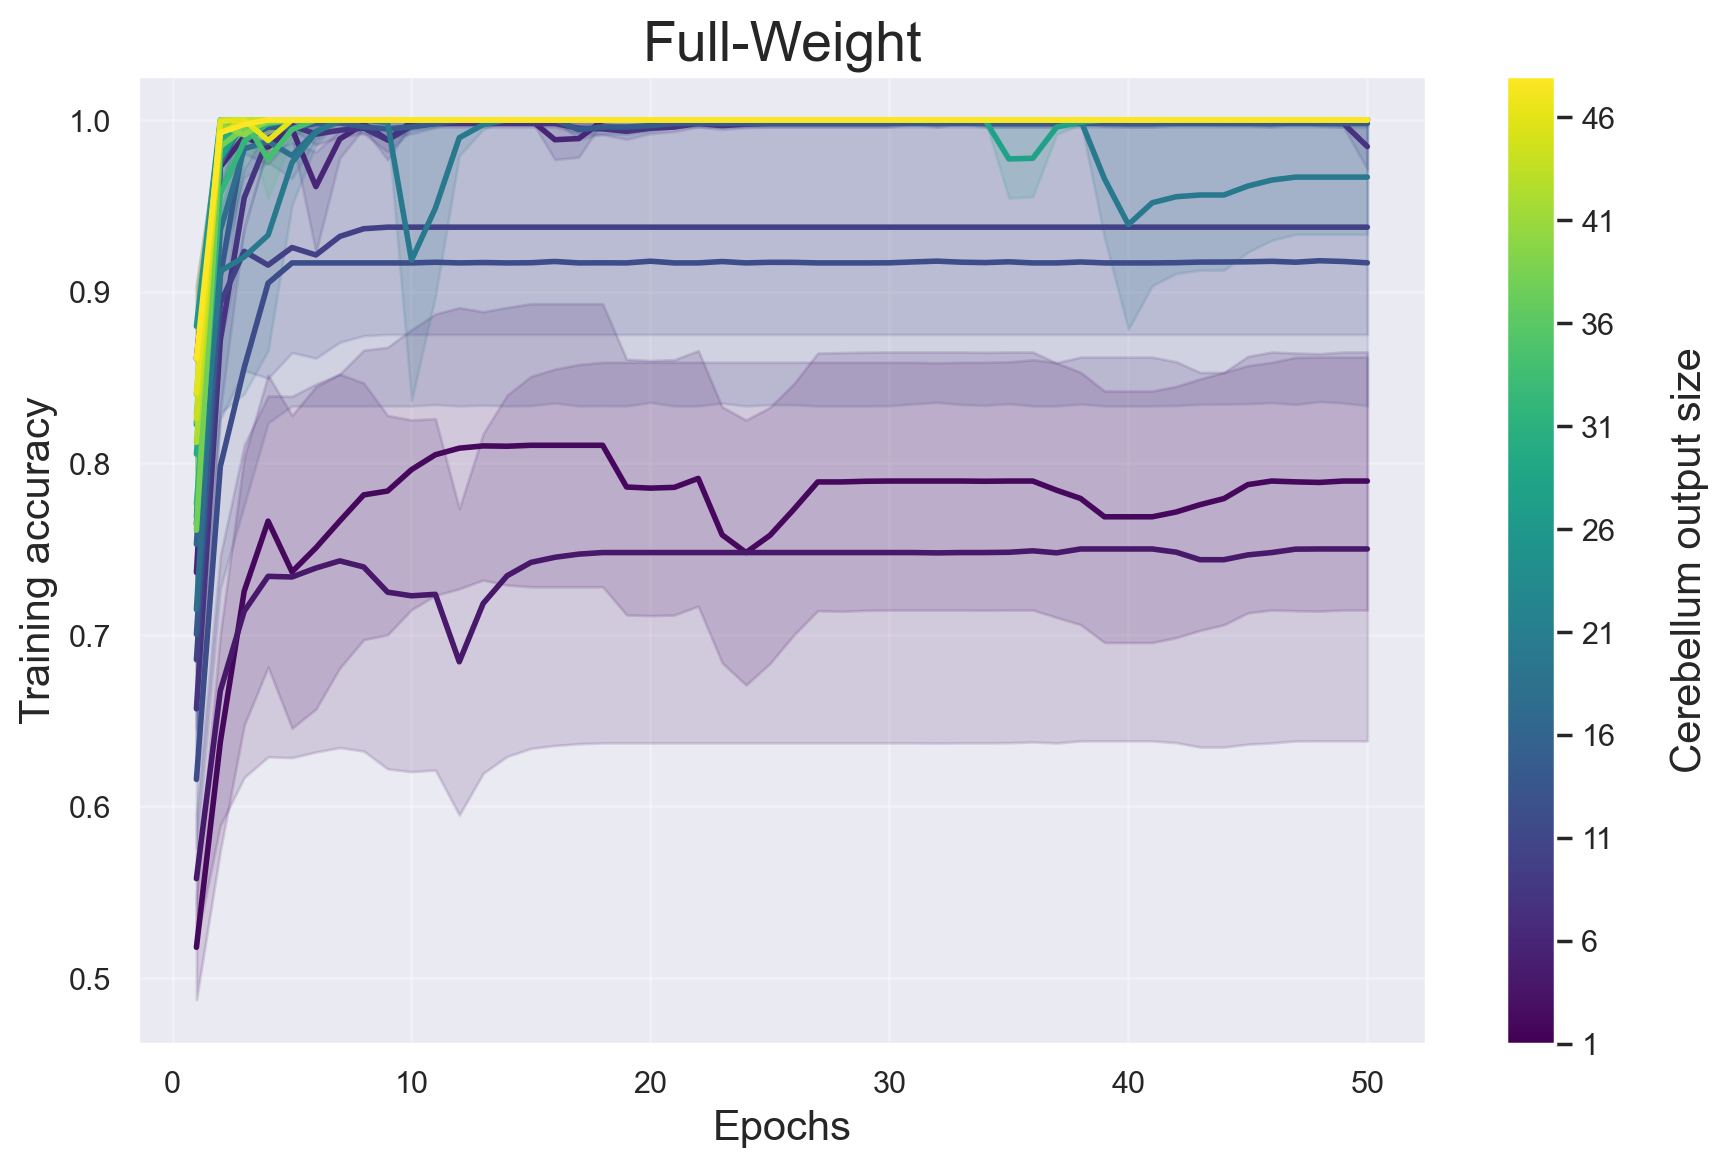

In [45]:
import re
import numpy as np
import matplotlib.pyplot as plt

def _parse_size_from_variant(name: str):
    m = re.search(r'(\d+)$', name)
    return int(m.group(1)) if m else name  # fallback to the name if no trailing number

def _stack_seed_series(series_list):
    """
    Take a list of lists (one per seed), align by min length, and stack.
    Returns: epochs (1..T), arr[T, S], where S = #seeds.
    """
    if not series_list:
        return np.arange(0), np.zeros((0, 0))
    lengths = [len(s) for s in series_list if s is not None]
    T = min(lengths) if lengths else 0
    if T == 0:
        return np.arange(0), np.zeros((0, 0))
    arr = np.stack([np.asarray(s[:T], dtype=float) for s in series_list], axis=1)  # [T, S]
    epochs = np.arange(1, T + 1)
    return epochs, arr


import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib as mpl

def plot_controller_size_learning_curves_with_cbar(runner, metric_key='train_accuracies', cmap='viridis'):
    fig, ax = plt.subplots(figsize=(9, 6))

    # sort variants and get sizes
    variant_items = sorted(runner.results.items(), key=lambda kv: _parse_size_from_variant(kv[0]))
    sizes = np.array([_parse_size_from_variant(name) for name, _ in variant_items], dtype=float)
    norm = mpl.colors.Normalize(vmin=sizes.min(), vmax=sizes.max())
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

    for variant_name, variant_blob in variant_items:
        size_val = _parse_size_from_variant(variant_name)
        color = scalar_map.to_rgba(size_val)

        results_list = variant_blob.get('training_results', [])
        per_seed_series = []
        for res in results_list:
            series = res.get('train_accuracies', None)
            if series is not None:
                per_seed_series.append(series)

        epochs, arr = _stack_seed_series(per_seed_series)
        if arr.size == 0:
            continue

        mean = arr.mean(axis=1)
        sem  = arr.std(axis=1, ddof=1) / np.sqrt(arr.shape[1]) if arr.shape[1] > 1 else None

        ax.plot(epochs, mean, lw=2, color=color)
        if sem is not None:
            ax.fill_between(epochs, mean - sem, mean + sem, alpha=0.15, color=color)

    ax.set_xlabel("Epochs",fontsize=15)
    ax.set_ylabel("Training accuracy", fontsize=15)
    ax.set_title("Full-Weight", fontsize=20)
    ax.grid(True, alpha=0.3)
    #ax.set_ylim(0.5, 1.1)

    # add colorbar tied to this Axes
    cbar = fig.colorbar(scalar_map, ax=ax)
    cbar.set_label("\nCerebellum output size", fontsize=15)
    cbar.set_ticks(range(1, int(sizes.max()), 5))  # ticks every 2 units

    fig.tight_layout()
    plt.show()


# usage:
plot_controller_size_learning_curves_with_cbar(runner)

In [ ]:
# Plot training analysis and decoding results for the controlled RNN variant
plot_training_analysis(runner.results['controlled_rnn']['training_results'])
plot_decoding_learning(
    runner.results['controlled_rnn']['decoding_scores'],
    task_descriptions=task_descriptions,
    fig_title="Decoding over learning"
)
plot_decoding_learning(
    runner.results['controlled_rnn']['xgen_decoding_scores'],
    task_descriptions=task_descriptions,
    fig_title="Cross-generalised decoding over learning"
)

In [ ]:
import matplotlib.pyplot as plt

def plot_controller_size_learning_curves(runner):
    plt.figure(figsize=(8, 6))

    for variant_name, result in runner.results.items():
        # Extract training accuracies from results
        accuracies = result['accuracy']  # list over epochs

        # Extract controller size from variant name (e.g., "standard_controller10")
        # This assumes your variant names always end in the controller output size
        size = variant_name.split("controller")[-1]

        plt.plot(range(1, len(accuracies)+1),
                 accuracies,
                 label=f"Controller size {size}")

    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.title("Effect of Controller Output Size on Learning Speed")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage
plot_controller_size_learning_curves(runner)


## Step 7: Run Multiple Instances of Two Model Variants, Over Two Training Phases

In [ ]:
# Define model variants
variants_phase1 = [
    # Variant 1: Simple RNN (no controller)
    {
        "name": "standard",
        "phase": 1,
        "plasticity": {
            "input_plastic": True,
            "hidden_plastic": True,
            "output_plastic": True,
            "h2controller_plastic": False,
            "controller2h_plastic": False,
            "controller_hidden_plastic": False,
        },

        "model": {
            "controller": {
                'enabled': False,
            }
        },
        "training": {
            "activations_l2": 0.0025,
            "weight_decay": 0.002,
        },
        "data":{
            'task_indices': [14]            
        },
    },

    # Variant 2: Controlled RNN
    {
        "name": "controlled_rnn",
        "phase": 1,
        "plasticity": {
            "input_plastic": False,
            "hidden_plastic": False,
            "output_plastic": True,
            "h2controller_plastic": True,
            "controller2h_plastic": True,
            "controller_hidden_plastic": True,
        },
        "model": {
            "controller": {
                'enabled': True,
            }
        },
        "training": {
            "activations_l2":  0.0025,
            "weight_decay": 0.002,
        },
        "data":{
            'task_indices': [14]            
        },
    },
]

variants_phase2 = [
    # Variant 1: Simple RNN (no controller)
    {
        "name": "simple_rnn",
        "phase": 2,
        "plasticity": {
            "input_plastic": True,
            "hidden_plastic": True,
            "output_plastic": True,
            "h2controller_plastic": False,
            "controller2h_plastic": False,
            "controller_hidden_plastic": False,
        },

        "model": {
            "controller": {
                'enabled': False,
            }
        },
        "training": {
            "activations_l2": 0.0025,
            "weight_decay": 0.002,
        },
        "data":{
            'task_indices': [16]            
        },
    },

    # Variant 2: Controlled RNN
    {
        "name": "controlled_rnn",
        "phase": 2,
        "plasticity": {
            "input_plastic": False,
            "hidden_plastic": False,
            "output_plastic": True,
            "h2controller_plastic": False,
            "controller2h_plastic": True,
            "controller_hidden_plastic": False,
        },
        "model": {
            "controller": {
                'enabled': True,
            }
        },
        "training": {
            "activations_l2": 0.0025,
            "weight_decay": 0.002,
        },
        "data":{
            'task_indices': [16]            
        },
    },
]


# Run the experiments
runner = ExperimentRunner(config_path)
# Run phase 1
runner.run_experiments(variants_phase1)
results_phase1 = copy.deepcopy(runner.results)

# Run phase 2 (continuing from phase 1 models)
runner.run_experiments(variants_phase2)
results_phase2 = runner.results


In [ ]:
task_descriptions = {
    0: "Colour",
    9: "Shape",
    20: "Width",
    14:  "XOR", 
    16:  "Task 16?"
}

In [ ]:
from src.analysis.utils import combine_phase_results
combined_results = combine_phase_results(results_phase1, results_phase2)

plot_training_analysis(combined_results['simple_rnn']['training_results'])
plot_decoding_learning(
    combined_results['simple_rnn']['decoding_scores'],
    task_descriptions=task_descriptions,
    fig_title="Decoding over learning"
)
plot_decoding_learning(
    combined_results['simple_rnn']['xgen_decoding_scores'],
    task_descriptions=task_descriptions,
    fig_title="Cross-generalised decoding over learning"
)

In [ ]:
plot_training_analysis(combined_results['controlled_rnn']['training_results'])
plot_decoding_learning(
    combined_results['controlled_rnn']['decoding_scores'],
    task_descriptions=task_descriptions,
    fig_title="Decoding over learning"
)
plot_decoding_learning(
    combined_results['controlled_rnn']['xgen_decoding_scores'],
    task_descriptions=task_descriptions,
    fig_title="Cross-generalised decoding over learning"
)